In [27]:
import pandas as pd

df = pd.read_csv('negative.csv', na_values=['NULL'])

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                                     12SL_Codes Source  \
0   HR00001                                        22,1684  PTBXL   
1   HR00002                      21,542,1665,531,1666,1693  PTBXL   
2   HR00003                                        22,1684  PTBXL   
3   HR00004  19,177,222,177,246,380,542,1665,533,1666,1693  PTBXL   
4   HR00005                                        22,1684  PTBXL   

             Phys_Codes  MI_12SL  MI_Phys  TestID  PatientAge  Gender  \
0  251146004, 426783006        0        0       1         NaN     NaN   
1  426177001, 426783006        0        0       2         NaN     NaN   
2             426783006        0        0       3         NaN     NaN   
3             426783006        0        0       4         NaN     NaN   
4             426783006        0        0       5         NaN     NaN   

  AcquisitionDateTime_DT  ...  STDOWN_V6  STELEV_V6  JELEV_V6  DLTWV_V6  \
0    2020-04-23 07:59:54  ...          2          4         0         0

In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [49]:
y = df['MI_Phys']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys']), y, test_size=0.2, random_state=42)

y_12SL = X_test['MI_12SL']

#drop the 12SL column
X_test = X_test.drop(columns=['MI_12SL'])
X_train = X_train.drop(columns=['MI_12SL'])


In [30]:
#count number of positive and negative smales based on MI_Phys
print(df['MI_Phys'].value_counts())

MI_Phys
0    63927
1     3968
Name: count, dtype: int64


In [42]:
estimators = [0.15, 0.11, 0.1, 0.09, 0.08, 0.07]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 100,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            #'scale_pos_weight': 63927/3968,
            #'is_unbalance': True
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.9454
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.9429
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.9439
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.9453
Learning rate: 0.11, Number of Leaves: 15 F1 score: 0.9443
Learning rate: 0.11, Number of Leaves: 31 F1 score: 0.9454
Learning rate: 0.11, Number of Leaves: 63 F1 score: 0.9450
Learning rate: 0.11, Number of Leaves: 127 F1 score: 0.9454
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.9443
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.9451
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.9457
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.9459
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.9452
Learning rate: 0.09, Number of Leaves: 31 F1 score: 0.9442
Learning rate: 0.09, Number of Leaves: 63 F1 score: 0.9453
Learning rate: 0.09, Number of Leaves: 127 F1 score: 0.9454
Learning rate: 0.08, Number of Leaves: 15 F1 score: 0.94

KeyboardInterrupt: 

In [ ]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.15,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 63927/3968,
    #'is_unbalance': True

    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print("Final F1 score: ", score)





Final F1 score:  0.9569924147580824


KeyError: 'MI_12SL'

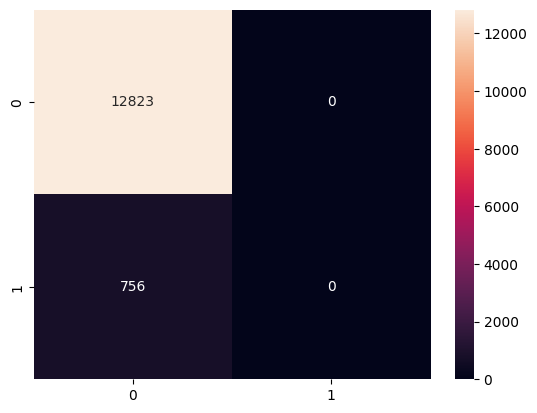

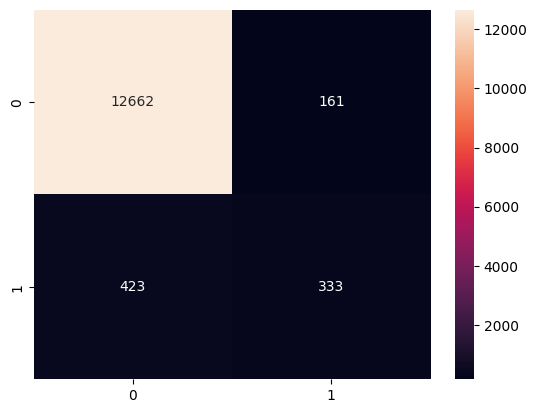

In [51]:
#confusion matrix 12SL (no model)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test, y_12SL)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


#confusion matrix (from model)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

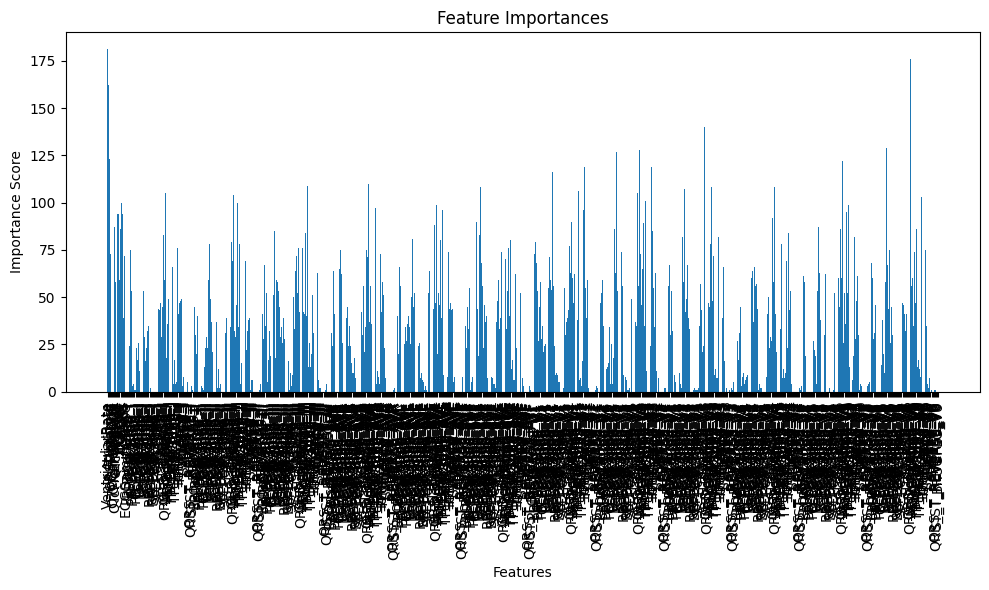

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained LightGBM model
importances = model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


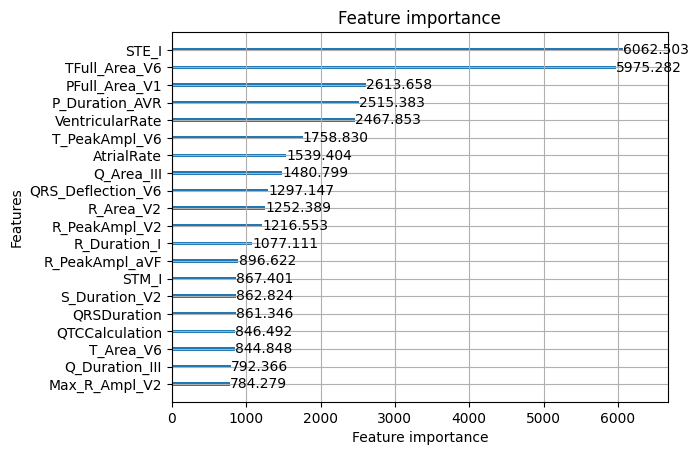

In [34]:
# 'gbm' is the model returned by lgb.train
booster = model.booster_
importances = booster.feature_importance(importance_type='split')  # or use 'gain'
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Number of components selected: 274
Total variance explained: 0.9503453841986094
Variance explained by each component: [0.07138166 0.05686371 0.04651962 0.03863669 0.03403071 0.03045029
 0.02510098 0.02220052 0.01942213 0.01763596 0.01618436 0.01538212
 0.01496859 0.01369802 0.01235228 0.01172646 0.01078413 0.01019476
 0.01004691 0.00909832 0.00857864 0.0077722  0.00763337 0.00757727
 0.0074205  0.00698402 0.006312   0.0062756  0.00618439 0.00606509
 0.00586477 0.00578576 0.00570109 0.00538757 0.00515766 0.0049998
 0.0049767  0.00478553 0.00471745 0.00458615 0.00450613 0.00445425
 0.0044031  0.00418683 0.00414715 0.00413401 0.00404325 0.00398036
 0.00387204 0.00382811 0.00375094 0.00371143 0.00360146 0.00356537
 0.00347347 0.0034569  0.00341657 0.00336607 0.00328691 0.00322449
 0.00321342 0.00318444 0.00313293 0.00308112 0.00300817 0.00297644
 0.00294341 0.00290395 0.00286511 0.00283157 0.00279622 0.00275637
 0.0027179  0.00269842 0.00266425 0.00263372 0.00263206 0.00254832
 0.00252495 

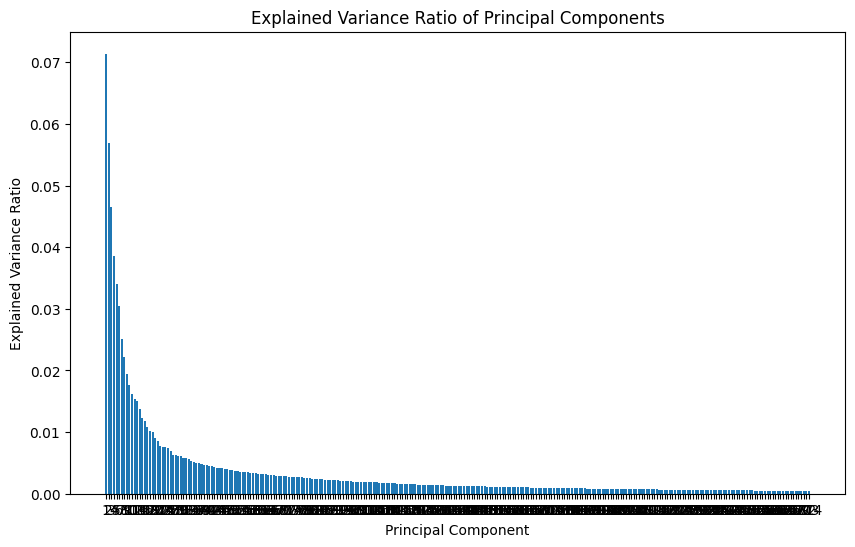

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cols = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys'])
# drop NaN values
df_cols = df_cols.dropna()
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())
print("Variance explained by each component:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)
#column names from original data
feature_names = df_cols.columns
# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

In [64]:
df_cols_Y = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT'])
# drop NaN values
df_cols_Y = df_cols_Y.dropna()
y = df_cols_Y['MI_Phys']
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)
#count number of positive and negative smales based on MI_Phys
print(df_cols_Y['MI_Phys'].value_counts())



MI_Phys
0    50935
1     3239
Name: count, dtype: int64


In [ ]:
estimators = [0.25, 0.2, 0.15, 0.1, 0.09]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 100,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

In [66]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.15,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 50935/3239,
    #'is_unbalance': True

    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print("Final F1 score: ", score)


Final F1 score:  0.946285186894324


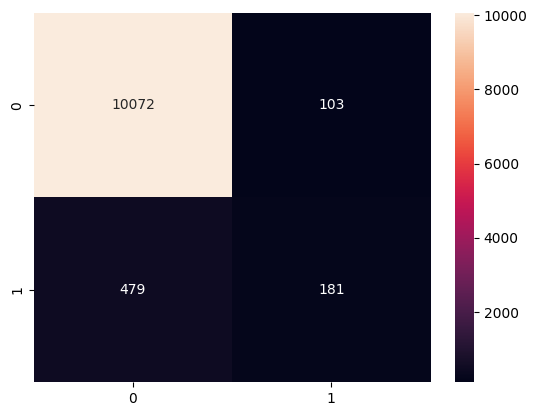

In [67]:
#confusion matrix 12SL (no model)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# cm = confusion_matrix(y_test, y_12SL)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.show()


#confusion matrix (from model)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()